In [3]:
!pip install qiskit-algorithms

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver

import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import COBYLA

  Using cached qiskit_algorithms-0.3.1-py3-none-any.whl.metadata (4.2 kB)
Using cached qiskit_algorithms-0.3.1-py3-none-any.whl (310 kB)


In [4]:
colors = ["red", "green", "blue", "white"]
cubes = [
    [("red", "green"), ("green", "white"), ("blue", "blue")],
    [("red", "red"), ("green", "white"), ("red", "blue")],
    [("red", "green"), ("green", "white"), ("blue", "white")],
    [("red", "blue"), ("green", "white"), ("blue", "white")],
]

/var/folders/53/xfcz6jxj1bd40h0b5lx9z7xw0000gn/T/ipykernel_20537/1440895562.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


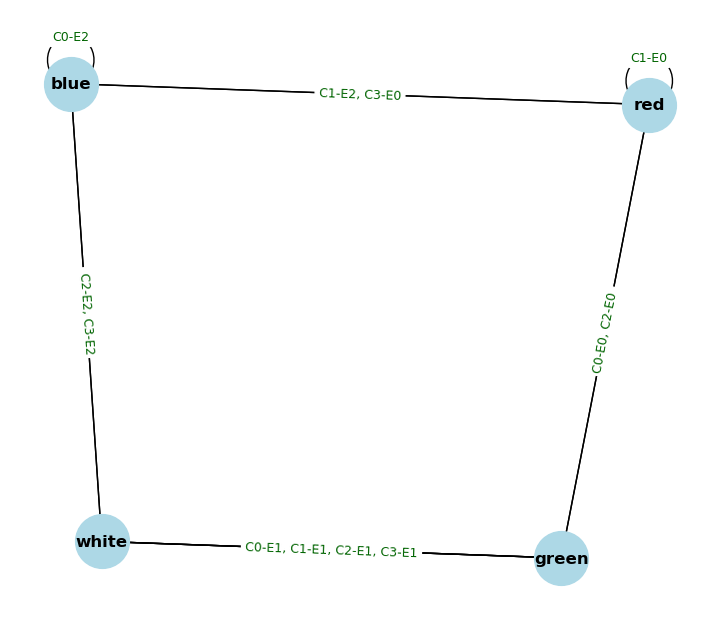

In [5]:
import networkx as nx
from collections import defaultdict

master_graph = nx.MultiGraph()
label_dict = defaultdict(list)

for cube_idx, cube_edges in enumerate(cubes):
    for edge_idx, (color1, color2) in enumerate(cube_edges):
        color1, color2 = sorted([color1, color2])
        label = f"C{cube_idx}-E{edge_idx}"
        master_graph.add_edge(color1, color2, label=label)
        label_dict[(color1, color2)].append(label)

edge_labels = {edge: ", ".join(labels) for edge, labels in label_dict.items()}

pos = nx.spring_layout(master_graph, seed=42)
plt.figure(figsize=(7, 6))
nx.draw(
    master_graph,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="lightblue",
    font_weight="bold",
)

nx.draw_networkx_edge_labels(
    master_graph, pos, edge_labels=edge_labels, font_color="darkgreen", font_size=9
)

plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
qp = QuadraticProgram("ii")

variables = {}  # ---> x_(g,i.j) == 1 if edge i of cube j is in the subgraph g

for g in ["g1", "g2"]:
    for i in range(len(cubes)):
        for j in range(len(cubes[i])):
            var = f"x_({(g, i, j)})"
            qp.binary_var(var)
            variables[(g, i, j)] = var

# ---- Constraint 1 : Each subgraphs should have only one edge from all the cubes ----
#      for each g and each i it has to satisfy "x_(g, i, 0) + x_(g, i, 1) + x_(g, i, 2) == 1"
#      equality constraint --> make this into the objective function
qp.minimize(constant=0, linear={}, quadratic={})

for g in ["g1", "g2"]:
    for i in range(len(cubes)):
        var_names = [variables[(g, i, j)] for j in range(3)]
        x0, x1, x2 = var_names

        qp.objective.constant += 1
        for v in var_names:
            qp.objective.linear[v] += -1
        qp.objective.quadratic[(x0, x1)] += 2
        qp.objective.quadratic[(x0, x2)] += 2
        qp.objective.quadratic[(x1, x2)] += 2


# ---- Constraint 2 : degree of all the vertices must be 2 ----
#
for g in ["g1", "g2"]:
    for color in colors:
        vars_with_color = []

        for i, cube in enumerate(cubes):
            for j, (c1, c2) in enumerate(cube):
                if color in (c1, c2):
                    vars_with_color.append(variables[(g, i, j)])

        qp.objective.constant += 4

        for v in vars_with_color:
            qp.objective.linear[v] += -3

        for i1 in range(len(vars_with_color)):
            for i2 in range(i1 + 1, len(vars_with_color)):
                v1 = vars_with_color[i1]
                v2 = vars_with_color[i2]
                qp.objective.quadratic[(v1, v2)] += 2

# ---- Constraint 3 : subgraphs g1 and g2 must be disjoint subgraphs of the master graph -----
#      x_(g1,i,j) + x_(g2,i,j) <= 1
for i in range(len(cubes)):
    for j in range(len(cubes[i])):
        var_g1 = variables[("g1", i, j)]
        var_g2 = variables[("g2", i, j)]

        qp.linear_constraint(
            linear={var_g1: 1, var_g2: 1}, sense="<=", rhs=1, name=f"dis_{i}_{j}"
        )


print(qp.prettyprint())

Problem name: ii

Minimize
  4*x_(('g1', 0, 0))*x_(('g1', 0, 1)) + 2*x_(('g1', 0, 0))*x_(('g1', 0, 2))
  + 2*x_(('g1', 0, 0))*x_(('g1', 1, 0)) + 2*x_(('g1', 0, 0))*x_(('g1', 1, 1))
  + 2*x_(('g1', 0, 0))*x_(('g1', 1, 2)) + 4*x_(('g1', 0, 0))*x_(('g1', 2, 0))
  + 2*x_(('g1', 0, 0))*x_(('g1', 2, 1)) + 2*x_(('g1', 0, 0))*x_(('g1', 3, 0))
  + 2*x_(('g1', 0, 0))*x_(('g1', 3, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 0, 2))
  + 4*x_(('g1', 0, 1))*x_(('g1', 1, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 2, 0))
  + 4*x_(('g1', 0, 1))*x_(('g1', 2, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 2, 2))
  + 4*x_(('g1', 0, 1))*x_(('g1', 3, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 3, 2))
  + 2*x_(('g1', 0, 2))*x_(('g1', 1, 2)) + 2*x_(('g1', 0, 2))*x_(('g1', 2, 2))
  + 2*x_(('g1', 0, 2))*x_(('g1', 3, 0)) + 2*x_(('g1', 0, 2))*x_(('g1', 3, 2))
  + 2*x_(('g1', 1, 0))*x_(('g1', 1, 1)) + 4*x_(('g1', 1, 0))*x_(('g1', 1, 2))
  + 2*x_(('g1', 1, 0))*x_(('g1', 2, 0)) + 2*x_(('g1', 1, 0))*x_(('g1', 3, 0))
  + 2*x_(('g1', 1, 1))*x_(('g1', 1, 2))

In [7]:
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)

In [8]:
exact = NumPyMinimumEigensolver()
optimizer_exact = MinimumEigenOptimizer(exact)

In [9]:
result_exact = optimizer_exact.solve(qubo)
print(result_exact.prettyprint())

objective function value: 0.0
variable values: x_(('g1', 0, 0))=0.0, x_(('g1', 0, 1))=1.0, x_(('g1', 0, 2))=0.0, x_(('g1', 1, 0))=0.0, x_(('g1', 1, 1))=0.0, x_(('g1', 1, 2))=1.0, x_(('g1', 2, 0))=1.0, x_(('g1', 2, 1))=0.0, x_(('g1', 2, 2))=0.0, x_(('g1', 3, 0))=0.0, x_(('g1', 3, 1))=0.0, x_(('g1', 3, 2))=1.0, x_(('g2', 0, 0))=1.0, x_(('g2', 0, 1))=0.0, x_(('g2', 0, 2))=0.0, x_(('g2', 1, 0))=0.0, x_(('g2', 1, 1))=1.0, x_(('g2', 1, 2))=0.0, x_(('g2', 2, 0))=0.0, x_(('g2', 2, 1))=0.0, x_(('g2', 2, 2))=1.0, x_(('g2', 3, 0))=1.0, x_(('g2', 3, 1))=0.0, x_(('g2', 3, 2))=0.0
status: SUCCESS


In [10]:
def draw_subgraph(subgraph_name, cubes, variables, result_dict, pos=None):
    G = nx.Graph()

    for i, cube in enumerate(cubes):
        for j, (c1, c2) in enumerate(cube):
            var_name = variables[(subgraph_name, i, j)]
            if result_dict[var_name] == 1.0:
                G.add_edge(c1, c2, label=f"cube {i}, edge {j}")

    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    edge_labels = nx.get_edge_attributes(G, "label")

    plt.figure(figsize=(5, 4))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        node_size=1000,
        font_weight="bold",
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
    plt.title(f"Subgraph {subgraph_name.upper()}")
    plt.axis("off")
    plt.show()

    return pos

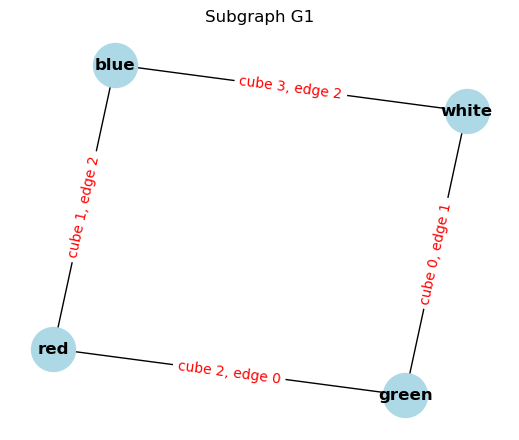

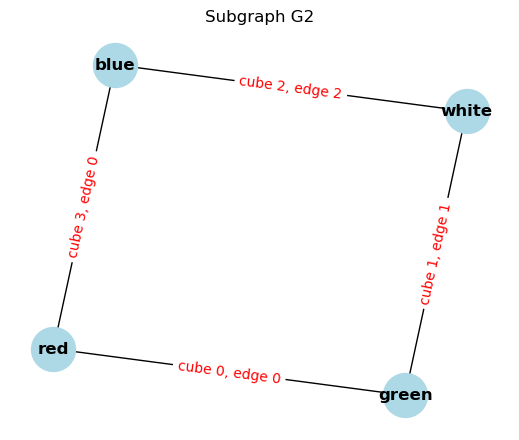

{'green': array([ 0.70195372, -0.99004852]),
 'white': array([0.99956111, 0.71119376]),
 'red': array([-1.        , -0.71153882]),
 'blue': array([-0.70151483,  0.99039358])}

In [15]:
pos_exact = draw_subgraph("g1", cubes, variables, result_exact.variables_dict)
draw_subgraph("g2", cubes, variables, result_exact.variables_dict, pos=pos_exact)